In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

import warnings
warnings.filterwarnings('ignore')
np.random.seed(8889)
%matplotlib inline

# Simulation 1

Procedure of the experiment

Automatic dimensionality selection from the scree plot via the use of profile likelihood
Mu Zhu∗, Ali Ghodsi

***
We have to note that these function all take in as input a Matrix do the PCA with 

1.&emsp; Create matrix $A =  S \Lambda S^{-1}$ by generating eigenvalues with following distributions and corresponding unit norm eigenvectors 

2.&emsp; The two distributions are (a) $\lambda_1...\lambda_{50}$ ~ Uniform(0, 45), $\lambda_{51}...\lambda_{100}$ ~ Uniform(55, 100); Here we expect to see that screen plot elbow at 50. For distribution (b) $\lambda_1...\lambda_{80}$ ~ Uniform(0, 49), $\lambda_{81}...\lambda_{100}$ ~ Uniform(51, 100); Here we expect the elbow to be at 20. The eigenvectors do not need to be orthonormal since we do not need this matrix to be symetric

3.&emsp; Generate 100 A matrices then take the median of the first elbow guess for ZG(2) and minka from the 100 trials. 


In [9]:
from scipy import linalg
#X_sim = np.random.normal(0, 1, (100, 200))
#U, S, Vt = linalg.svd(X_sim)
#e_vec = U[:, :100]
l1 = np.random.randint(0, 20, 50)
l2 = np.random.randint(80, 100, 50)
Lam = np.diag(list(l1) + list(l2))
#A = e_vec @ Lam @ np.linalg.inv(e_vec)
#A.shape
A = np.identity(100) @ Lam @np.identity(100)
A.shape


(100, 100)

In [14]:
A

array([[ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., 15.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 12., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 88.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 95.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 86.]])

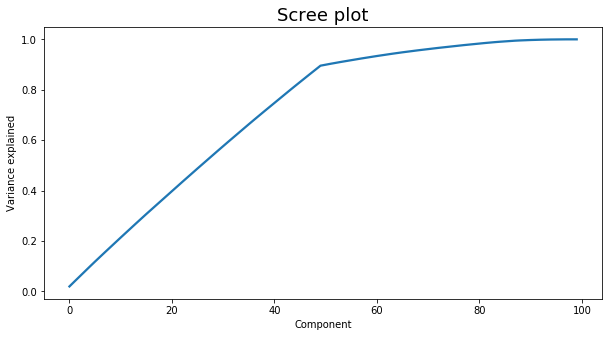

In [10]:
from graspologic.plot import screeplot
screeplot(A)

In [11]:
from graspologic.embed import select_dimension
select_dimension(A)

([6], [97.00000000000001])

In [12]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components='mle', svd_solver='full')
pca.fit(A)

ValueError: math domain error

In [13]:
from sklearn.utils.extmath import svd_flip
from sklearn.decomposition._pca import _infer_dimension
from scipy import linalg

def minka(X):
    n_components = 'mle'
    n_samples = X.shape[0]
    U, S, Vt = linalg.svd(X, full_matrices=False)
    # flip eigenvectors' sign to enforce deterministic output
    U, Vt = svd_flip(U, Vt)

    components_ = Vt

    # Get variance explained by singular values
    explained_variance_ = (S ** 2) / (n_samples - 1)
    total_var = explained_variance_.sum()
    explained_variance_ratio_ = explained_variance_ / total_var
    singular_values_ = S.copy()  # Store the singular values.

    # Postprocess the number of components required
    if n_components == 'mle':
        n_components = \
            _infer_dimension(explained_variance_, n_samples)
    return n_components

minka(A)

ValueError: math domain error

In [11]:
from sklearn.decomposition import PCA as pca
your_pca = pca(n_components = "mle", svd_solver ="full")
your_pca.fit_transform(A)
print(your_pca.explained_variance_)

ValueError: math domain error

In [38]:
dims_1 = []
dims_2 = []
for i in range(100):
    l1 = np.random.randint(0, 46, 50)
    l2 = np.random.randint(55, 101, 50)
    Lam = np.diag(list(l1) + list(l2))
    A = np.identity(100) @ Lam @np.identity(100)
    d = select_dimension(A)
    # due to the function not always returning two element list we only append the first 
    dims_1.append(d[0][0])
dims_1 = np.asarray(dims_1)
dims_2 = np.asarray(dims_2)

In [40]:
np.median(dims_1)

4.0

# Simulation 2

Procedure of the experiment
Automatic dimensionality selection from the scree plot via the use of profile likelihood
Mu Zhu∗, Ali Ghodsi

***

This deals with linear subspaces

1.&emsp; Generate 5 basis vectors $B = b_1, ..., b_5$ that lie in $R^{50}$ with Standard normal Gaussian. 

2.&emsp; Randomly generate 200 random data points in $R^{50}$ and then add noise. In effect generate 10000 from standard Gaussian and arrange them in Z = 50x200 matrix. 

3.&emsp; Generate E a 50x200 . $$ E = \begin{bmatrix} normal(\mu, \sigma) & \dots \\ \vdots & \ddots & \\ \end{bmatrix}$$ such that $\mu = 0, \sigma = .75$

4.&emsp; then we do PCA on $A = B(B^T B)^{-1}B^T Z + E $. Note that here we can test how resistant minka and ZG(2) are to noise by changin $\mu, \sigma$.

5.&emsp; when applying dimension estimation we should see after running 100 trials and taking median from both minka and ZG(2) are 5




In [15]:
a = np.random.normal(0, 1, (50, 5))
B, _ = np.linalg.qr(a)
Z = np.random.random(size=(50, 200))
E = np.random.normal(0, .75, (50, 200))
A = (B @ np.linalg.inv(np.transpose(B) @ B) @ np.transpose(B) @ Z) + E
minka(A)

46

In [16]:
select_dimension(A)

([2, 5], [15.465024639273231, 14.756591370093005])

In [17]:
dim_minka = []
dim_zg = []
for i in range(100):
    a = np.random.normal(0, .75, (50, 5))
    B, _ = np.linalg.qr(a)
    Z = np.random.random(size=(50, 200))
    E = np.random.normal(0, .75, (50, 200))
    A = (B @ np.linalg.inv(np.transpose(B) @ B) @ np.transpose(B) @ Z) + E
    dim_minka.append(minka(A))
    dim_zg.append(select_dimension(A)[0][0])

In [18]:
from graspologic.plot import screeplot
screeplot(A)
#plt.axvline(2, label='True rank {}'.format(2), color='red')
#plt.axvline(4, label='Est rank {}'.format(4), color='blue', ls='--')
#plt.axvline(2, label='Est rank {}'.format(4), color='blue', ls='--')
#plt.legend()

ValueError: n_components must be <= min(X.shape).

In [19]:
A.shape

(50, 200)

In [82]:
np.median(dim_zg)

1.0

In [83]:
np.median(dim_minka)

43.5

## Nonlinear? Real data? 

like a swiss roll or using MNIST? 

# Simulation 3

Procedure of the experiment

Automatic choice of dimensionality for PCA
Thomas P. Minka

***

noise and data density checks

NIPS-2000-automatic-choice-of-dimensionality-for-pca-Paper.pdf

1.&emsp; Testing high density data N >>> d.  In this case we will have $R^{10}$ and generate random evecs from a standard gaussian distrubtion. We will then have a 10x100 array A. the first 5 dimensions are signal and the last five dimensions are noise. So when doing dimenstion selection we should get output 5
